# Combine Random Forest + LSTM

missing values in dataset: 
date         0
cases_new    0
dtype: int64
length of dataset:  1716
date         datetime64[ns]
cases_new             int64
dtype: object
            count                           mean                  min  \
date         1716  2022-05-31 12:00:00.000000256  2020-01-25 00:00:00   
cases_new  1716.0                    3097.769814                  0.0   

                           25%                  50%                  75%  \
date       2021-03-28 18:00:00  2022-05-31 12:00:00  2023-08-03 06:00:00   
cases_new                131.0                851.5               3246.5   

                           max          std  
date       2024-10-05 00:00:00          NaN  
cases_new              33406.0  5621.640214  
missing values in dataset: 
date         0
cases_new    0
dtype: int64


,date,cases_new
0,2020-01-25,4
1,2020-01-26,0
2,2020-01-27,0
3,2020-01-28,0
4,2020-01-29,3
5,2020-01-30,1
6,2020-01-31,0
7,2020-02-01,0
8,2020-02-02,0
9,2020-02-03,0


Total number of rows: 1716
Scaler saved successfully.
Mean Absolute Error (MAE): 0.0024879666477277164
Mean Squared Error (MSE): 2.858951221627415e-05
Root Mean Squared Error (MSE): 0.00534691614075573


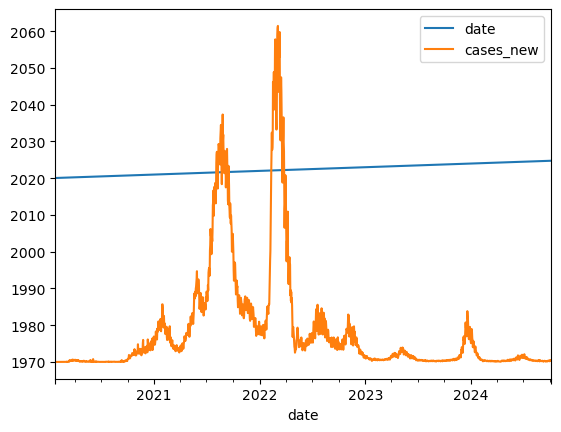

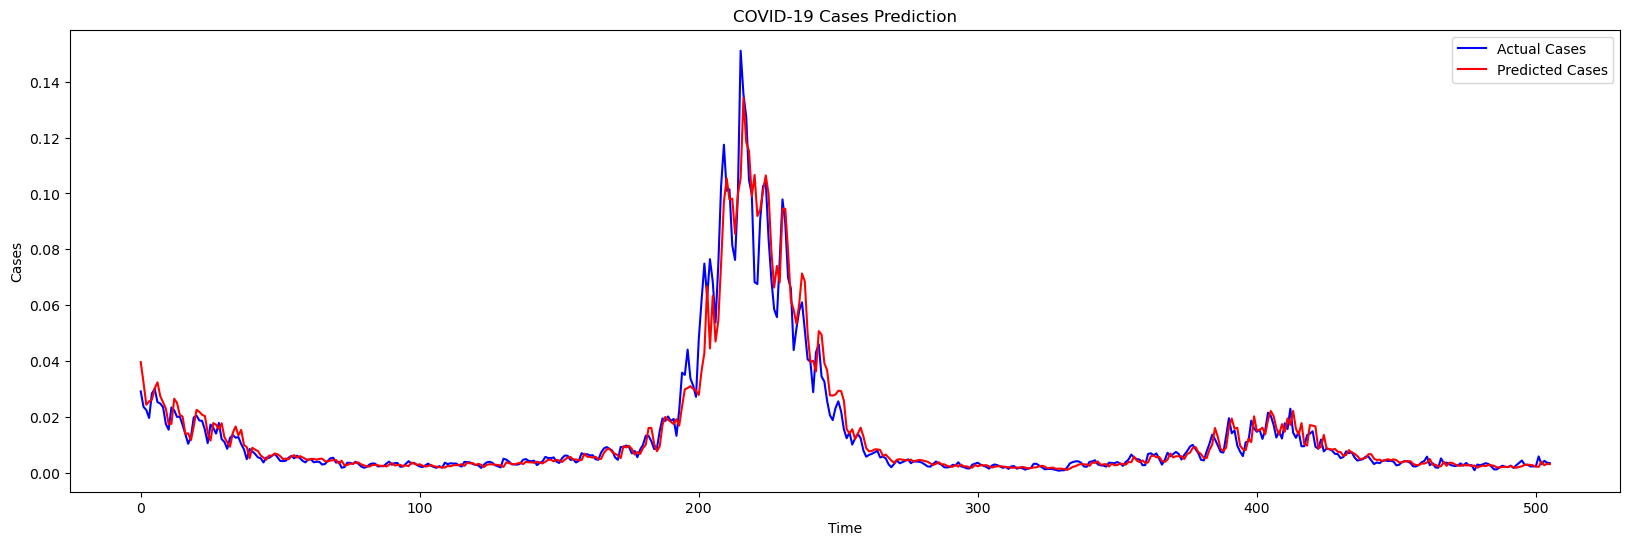

In [1]:
# Import libraries
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import joblib
import os

# Load the dataset, only columns date,state,new
# Load the dataset
df = pd.read_csv('../datasets/cases_state.csv', usecols=['date', 'state', 'cases_new'])

# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

#set the index as 'date'
df_grouped.index = df_grouped['date']

# Set the frequency of the DataFrame's index to daily ('D')
df_grouped = df_grouped.asfreq('D')

# Check for missing values
print("missing values in dataset: ")
print(df_grouped.isna().sum())

# Fill or drop missing values
df_grouped.fillna(0, inplace=True)

# Check the length of the dataset
print("length of dataset: ", len(df_grouped))

#check df_grouped type of data for both columns
print(df_grouped.dtypes)

#calculate the mean,std, count, min, max, 25%,50%,75%
print(df_grouped.describe().transpose())
df_grouped.plot()
# Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'],  format='%Y-%m-%d')

# Aggregate data by date if you want to plot the total new cases across all states per day
df_grouped = df.groupby('date')['cases_new'].sum().reset_index()

# Check for missing values
print("missing values in dataset: ")
print( df_grouped.isna().sum())

# Fill or drop missing values
df_grouped.fillna(0, inplace=True)

# Display the aggregated data
display(df_grouped.head(10))

# Get the total number of rows
total_rows = df_grouped.shape[0]
print("Total number of rows:", total_rows)

# sort by date order
df_grouped = df_grouped.sort_values(by='date')

#used to scale data into between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
#drop date columns because it doesn't need to be scaled, just cases_new column only
scaled_data = scaler.fit_transform(df_grouped.drop(['date'], axis=1))

# Save the scaler for use in Django
import joblib
joblib.dump(scaler, "../models/scaler.pkl")  # Adjust the path as needed
print("Scaler saved successfully.")

# Scaled data (Numpy array) is converted back into dataframe 
df_grouped_scaled = pd.DataFrame(scaled_data, columns=df_grouped.columns[1:])

#original 'date' is added back into new data frame 
df_grouped_scaled['date'] = df_grouped['date'].values

# Prepare the data for Random Forest
# Here we'll use a windowing technique similar to LSTM, but we need to reshape the data differently.
# We will create features for the last N days for predicting the current day's cases_new.

def create_features(data, target_col='cases_new', sequence_length=30):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])  # Last N days
        y.append(data[i][0])  # Current day's cases_new
    return np.array(X), np.array(y)

# Prepare the data for Random Forest model
data_for_rf = df_grouped_scaled.drop(['date'], axis=1).values
X, y = create_features(data_for_rf)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], -1), y, train_size=0.7, shuffle=False)

# Initialize the model
rf_regressor = RandomForestRegressor(n_estimators=200, random_state=42)
rf_regressor.fit(X_train, y_train)# Train the model
y_pred = rf_regressor.predict(X_test)# Make predictions

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (MSE): {rmse}")

# plot the graph for the 
plt.figure(figsize=(20, 6))
plt.plot(y_test, color='blue', label='Actual Cases')
plt.plot(y_pred, color='red', label='Predicted Cases')
plt.title('COVID-19 Cases Prediction')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
plt.show()

In [15]:
# Save the Random Forest model
rf_model_path = "../models/random_forest_model.pkl"
os.makedirs(os.path.dirname(rf_model_path), exist_ok=True)  # Ensure directory exists
joblib.dump(rf_regressor, rf_model_path)

print(f"Random Forest model saved to: {rf_model_path}")


Random Forest model saved to: ../models/random_forest_model.pkl


In [16]:
# Step 1: Generate sliding windows for the full dataset
def create_sliding_windows_flat(data, sequence_length=30):
    X = []
    for i in range(sequence_length, len(data)):
        # Flatten each sliding window into a 1D array
        X.append(data[i-sequence_length:i].flatten())  # Flatten to 1D array
    return np.array(X)

# Create the sliding window input for the entire dataset
X_rf_full = create_sliding_windows_flat(data_for_rf, sequence_length=30)

# Step 2: Predict using the Random Forest model
rf_full_predictions = rf_regressor.predict(X_rf_full)

# Step 3: Add RF predictions as a new feature to the scaled dataset
# Since the first 30 rows cannot be predicted, fill them with 0 (or NaN if you prefer)
rf_predictions_full = np.append([0] * 30, rf_full_predictions)

# Step 4: Add RF predictions as a new column
df_grouped_scaled['rf_predictions'] = rf_predictions_full

# Step 5: Scale the rf_predictions column
df_grouped_scaled['rf_predictions'] = scaler.fit_transform(
    df_grouped_scaled[['rf_predictions']]
)

print("RF predictions successfully added and scaled!")


RF predictions successfully added and scaled!


In [17]:
# Updated create_features function
def create_features_with_rf(data, sequence_length=30):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        # Use all columns (cases_new and rf_predictions) as features
        X.append(data[i-sequence_length:i, :])  # Last N days of all features
        y.append(data[i, 0])  # Predict cases_new (first column)
    return np.array(X), np.array(y)

# Prepare the new input dataset with RF predictions
data_for_lstm = df_grouped_scaled[['cases_new', 'rf_predictions']].values
X_lstm, y_lstm = create_features_with_rf(data_for_lstm)

# Split the dataset into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, train_size=0.7, shuffle=False)


In [46]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
import tensorflow as tf
import numpy as np
import random

# Set random seeds
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer for predicting cases_new

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# history = model.fit(X_train_lstm, y_train_lstm, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
history = model.fit(X_train_lstm, y_train_lstm, epochs=150, batch_size=32, validation_split=0.2, shuffle=False, callbacks=[es])


Epoch 1/150
30/30 [==============================] - 4s 54ms/step - loss: 0.0122 - val_loss: 0.0033
Epoch 2/150
30/30 [==============================] - 1s 28ms/step - loss: 0.0094 - val_loss: 0.0036
Epoch 3/150
30/30 [==============================] - 1s 28ms/step - loss: 0.0126 - val_loss: 0.0013
Epoch 4/150
30/30 [==============================] - 1s 30ms/step - loss: 0.0091 - val_loss: 1.5485e-04
Epoch 5/150
30/30 [==============================] - 1s 31ms/step - loss: 0.0038 - val_loss: 5.1086e-04
Epoch 6/150
30/30 [==============================] - 1s 31ms/step - loss: 0.0024 - val_loss: 2.0562e-04
Epoch 7/150
30/30 [==============================] - 1s 31ms/step - loss: 0.0021 - val_loss: 1.4814e-04
Epoch 8/150
30/30 [==============================] - 1s 34ms/step - loss: 0.0024 - val_loss: 3.5263e-04
Epoch 9/150
30/30 [==============================] - 1s 31ms/step - loss: 0.0024 - val_loss: 2.5811e-04
Epoch 10/150
30/30 [==============================] - 1s 31ms/step - loss: 0

16/16 [==============================] - 1s 14ms/step
Hybrid Model - Scaled Mean Absolute Error (MAE): 0.0037437296242908953
Hybrid Model - Scaled Mean Squared Error (MSE): 5.6790771976344994e-05
Hybrid Model - Scaled Root Mean Squared Error (RMSE): 0.007535965231895978


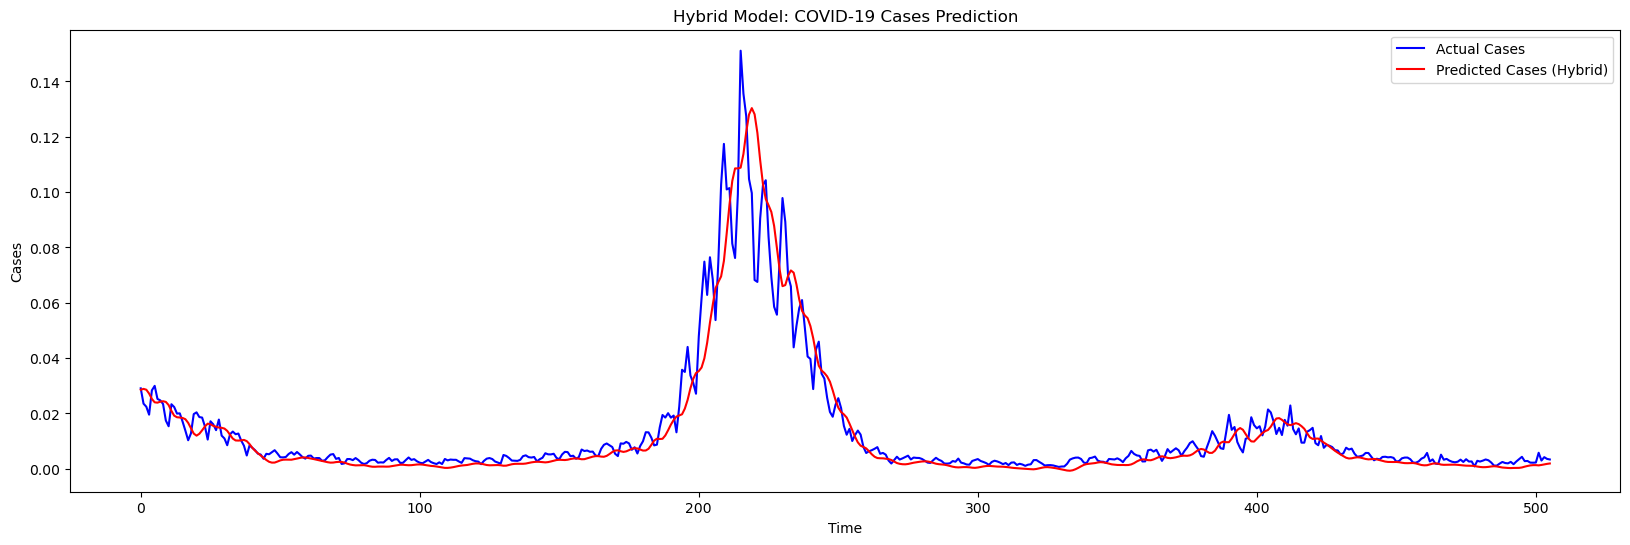

In [47]:
# Predict using the LSTM model
lstm_predictions = model.predict(X_test_lstm)

# No need to rescale predictions back to the original scale
# Use predictions and true values in their scaled space
# lstm_predictions and y_test_lstm are already scaled

# Calculate evaluation metrics directly on scaled data
mae_scaled = mean_absolute_error(y_test_lstm, lstm_predictions)
mse_scaled = mean_squared_error(y_test_lstm, lstm_predictions)
rmse_scaled = np.sqrt(mse_scaled)

print(f"Hybrid Model - Scaled Mean Absolute Error (MAE): {mae_scaled}")
print(f"Hybrid Model - Scaled Mean Squared Error (MSE): {mse_scaled}")
print(f"Hybrid Model - Scaled Root Mean Squared Error (RMSE): {rmse_scaled}")

# Plot predictions vs actual values
plt.figure(figsize=(20, 6))
plt.plot(y_test_lstm, color='blue', label='Actual Cases')
plt.plot(lstm_predictions, color='red', label='Predicted Cases (Hybrid)')
plt.title('Hybrid Model: COVID-19 Cases Prediction')
plt.xlabel('Time')
plt.ylabel('Cases')
plt.legend()
plt.show()


In [22]:
# Re-fit the scaler using only the original 'cases_new' column
scaler = MinMaxScaler()
scaler.fit(df_grouped[['cases_new']])

# Print scaler parameters for verification
print(f"Scaler min_: {scaler.min_}")
print(f"Scaler scale_: {scaler.scale_}")
# Correctly rescale using the re-fitted scaler
lstm_predictions_rescaled_corrected = scaler.inverse_transform(lstm_predictions)
y_test_rescaled_corrected = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Print corrected unscaled predictions and actual values
print("Corrected Unscaled Predictions (after fixing scaler):")
print(lstm_predictions_rescaled_corrected[:5].flatten())

print("\nCorrected Unscaled Actual Values (after fixing scaler):")
print(y_test_rescaled_corrected[:5].flatten())
# Recalculate metrics with corrected unscaled values
mae = mean_absolute_error(y_test_rescaled_corrected, lstm_predictions_rescaled_corrected)
mse = mean_squared_error(y_test_rescaled_corrected, lstm_predictions_rescaled_corrected)
rmse = np.sqrt(mse)

print(f"Corrected Unscaled MAE: {mae}")
print(f"Corrected Unscaled MSE: {mse}")
print(f"Corrected Unscaled RMSE: {rmse}")


Scaler min_: [0.]
Scaler scale_: [2.99347423e-05]
Corrected Unscaled Predictions (after fixing scaler):
[1008.3278   971.2549   948.38556  921.5382   884.17365]

Corrected Unscaled Actual Values (after fixing scaler):
[971. 786. 749. 653. 947.]
Corrected Unscaled MAE: 110.05396294122627
Corrected Unscaled MSE: 63041.082072533754
Corrected Unscaled RMSE: 251.0798320704667


In [38]:
# # Save the model in the native Keras format
# model.save("../models/hybrid_model.keras")

In [39]:
import os

# Check if the model file exists
model_path = "hybrid_model.keras"  # Or "hybrid_model.h5"
if os.path.exists(model_path):
    print(f"Model has been successfully saved at {model_path}")
else:
    print("Model saving failed!")


Model has been successfully saved at hybrid_model.keras


# Testing hybrid model keras

In [2]:
from keras.models import load_model

# Path to your saved model
saved_model_path = "../models/hybrid_model.keras"

# Load the model without compiling (ignoring the optimizer state)
modelhybrids = load_model(saved_model_path, compile=False)

modelhybrids.compile(optimizer='adam', loss='mean_squared_error')

print("Model loaded successfully!")


Model loaded successfully!


In [3]:
# Step 1: Generate sliding windows for the full dataset
def create_sliding_windows_flat(data, sequence_length=30):
    X = []
    for i in range(sequence_length, len(data)):
        # Flatten each sliding window into a 1D array
        X.append(data[i-sequence_length:i].flatten())  # Flatten to 1D array
    return np.array(X)

# Create the sliding window input for the entire dataset
X_rf_full = create_sliding_windows_flat(data_for_rf, sequence_length=30)

# Step 2: Predict using the Random Forest model
rf_full_predictions = rf_regressor.predict(X_rf_full)

# Step 3: Add RF predictions as a new feature to the scaled dataset
# Since the first 30 rows cannot be predicted, fill them with 0 (or NaN if you prefer)
rf_predictions_full = np.append([0] * 30, rf_full_predictions)

# Step 4: Add RF predictions as a new column
df_grouped_scaled['rf_predictions'] = rf_predictions_full

# Step 5: Scale the rf_predictions column
df_grouped_scaled['rf_predictions'] = scaler.fit_transform(
    df_grouped_scaled[['rf_predictions']]
)

print("RF predictions successfully added and scaled!")


RF predictions successfully added and scaled!


In [4]:
# Updated create_features function
def create_features_with_rf(data, sequence_length=30):
    X = []
    y = []
    for i in range(sequence_length, len(data)):
        # Use all columns (cases_new and rf_predictions) as features
        X.append(data[i-sequence_length:i, :])  # Last N days of all features
        y.append(data[i, 0])  # Predict cases_new (first column)
    return np.array(X), np.array(y)

# Prepare the new input dataset with RF predictions
data_for_lstm = df_grouped_scaled[['cases_new', 'rf_predictions']].values
X_lstm, y_lstm = create_features_with_rf(data_for_lstm)

# Split the dataset into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, train_size=0.7, shuffle=False)


16/16 [==============================] - 1s 11ms/step
Hybrid Model - Scaled Mean Absolute Error (MAE): 0.002312260788818114
Hybrid Model - Scaled Mean Squared Error (MSE): 2.4709296870644014e-05
Hybrid Model - Scaled Root Mean Squared Error (RMSE): 0.004970844683818236


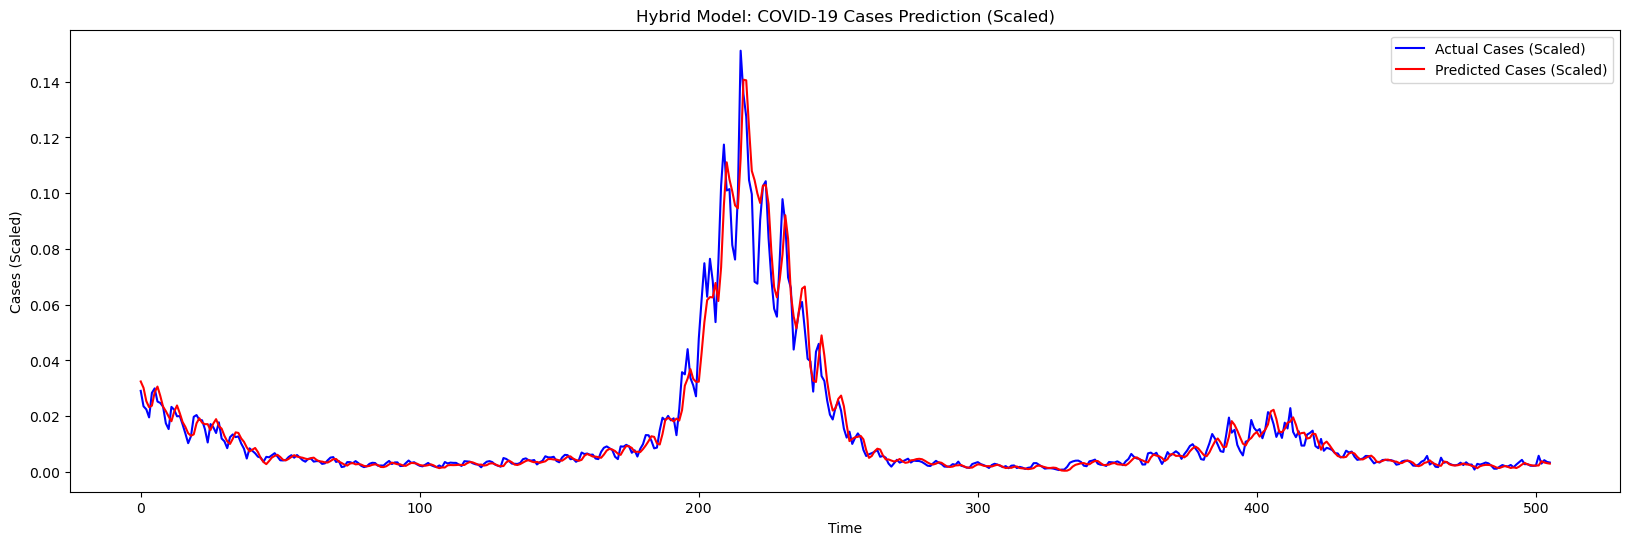

In [5]:
# Predict using the LSTM model
lstm_predictions = modelhybrids.predict(X_test_lstm)

# No need to rescale predictions back to the original scale
# Use predictions and true values in their scaled space
# lstm_predictions and y_test_lstm are already scaled

# Calculate evaluation metrics directly on scaled data
mae_scaled = mean_absolute_error(y_test_lstm, lstm_predictions)
mse_scaled = mean_squared_error(y_test_lstm, lstm_predictions)
rmse_scaled = np.sqrt(mse_scaled)

print(f"Hybrid Model - Scaled Mean Absolute Error (MAE): {mae_scaled}")
print(f"Hybrid Model - Scaled Mean Squared Error (MSE): {mse_scaled}")
print(f"Hybrid Model - Scaled Root Mean Squared Error (RMSE): {rmse_scaled}")

# Plot predictions vs actual values in scaled space
plt.figure(figsize=(20, 6))
plt.plot(y_test_lstm, color='blue', label='Actual Cases (Scaled)')
plt.plot(lstm_predictions, color='red', label='Predicted Cases (Scaled)')
plt.title('Hybrid Model: COVID-19 Cases Prediction (Scaled)')
plt.xlabel('Time')
plt.ylabel('Cases (Scaled)')
plt.legend()
plt.show()



In [6]:
# Re-fit the scaler using only the original 'cases_new' column
scaler = MinMaxScaler()
scaler.fit(df_grouped[['cases_new']])

# Print scaler parameters for verification
print(f"Scaler min_: {scaler.min_}")
print(f"Scaler scale_: {scaler.scale_}")
# Correctly rescale using the re-fitted scaler
lstm_predictions_rescaled_corrected = scaler.inverse_transform(lstm_predictions)
y_test_rescaled_corrected = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Print corrected unscaled predictions and actual values
print("Corrected Unscaled Predictions (after fixing scaler):")
print(lstm_predictions_rescaled_corrected[:5].flatten())

print("\nCorrected Unscaled Actual Values (after fixing scaler):")
print(y_test_rescaled_corrected[:5].flatten())
# Recalculate metrics with corrected unscaled values
mae = mean_absolute_error(y_test_rescaled_corrected, lstm_predictions_rescaled_corrected)
mse = mean_squared_error(y_test_rescaled_corrected, lstm_predictions_rescaled_corrected)
rmse = np.sqrt(mse)

print(f"Corrected Unscaled MAE: {mae}")
print(f"Corrected Unscaled MSE: {mse}")
print(f"Corrected Unscaled RMSE: {rmse}")


Scaler min_: [0.]
Scaler scale_: [2.99347423e-05]
Corrected Unscaled Predictions (after fixing scaler):
[1083.7034  1007.5547   848.0987   775.13434  792.9813 ]

Corrected Unscaled Actual Values (after fixing scaler):
[971. 786. 749. 653. 947.]
Corrected Unscaled MAE: 77.24338377134602
Corrected Unscaled MSE: 27574.607207420257
Corrected Unscaled RMSE: 166.0560363474338


In [43]:
modelhybrids.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 30, 128)           67072     
                                                                 
 dropout_25 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_26 (LSTM)              (None, 128)               131584    
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 198785 (776.50 KB)
Trainable params: 198785 (776.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:
print(f"Scaler min_: {scaler.min_}")
print(f"Scaler scale_: {scaler.scale_}")


Scaler min_: [0.]
Scaler scale_: [2.99347423e-05]


In [48]:
for layer_saved, layer_current in zip(modelhybrids.layers, model.layers):
    if np.array_equal(layer_saved.get_weights(), layer_current.get_weights()):
        print(f"Layer {layer_saved.name} weights match!")
    else:
        print(f"Layer {layer_saved.name} weights differ.")


Layer lstm_25 weights differ.
Layer dropout_25 weights match!
Layer lstm_26 weights differ.
Layer dropout_26 weights match!
Layer dense_12 weights differ.
